In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import probplot

In [116]:
df = pd.read_csv("Advertising.csv", delimiter=',', encoding='utf-8', index_col=0)
df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


# 1. Analizar correlación entre las variables

Para analizar la correlación entre las variables en nuestro conjunto de datos vamos a utilizar una matriz de correlación para analizar la relación lineal entre las distintas variables, una correlación cercana a 1 indica una tendencia más fuerte hacia una relación lineal entre las variables analizadas.

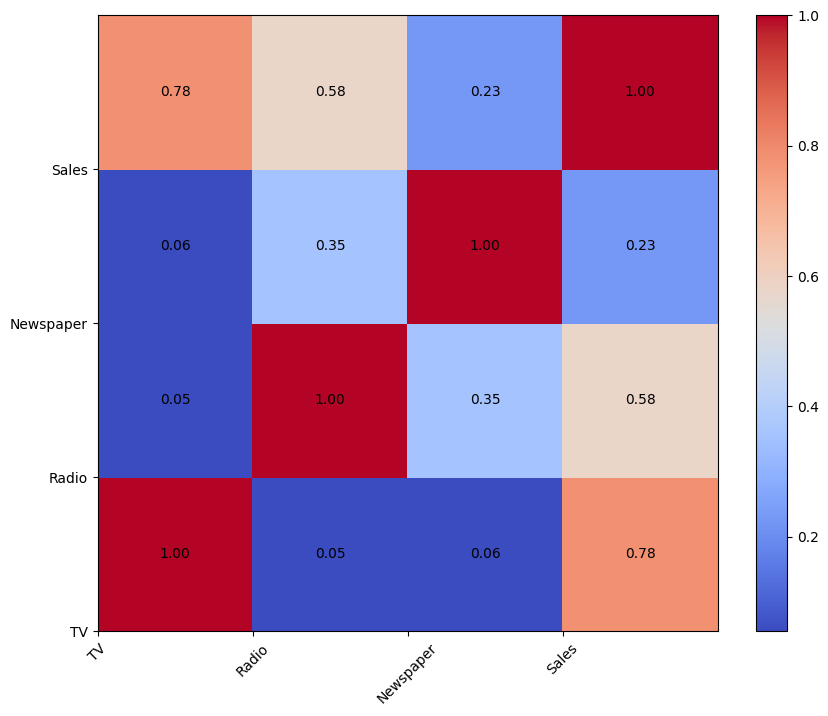

<Figure size 640x480 with 0 Axes>

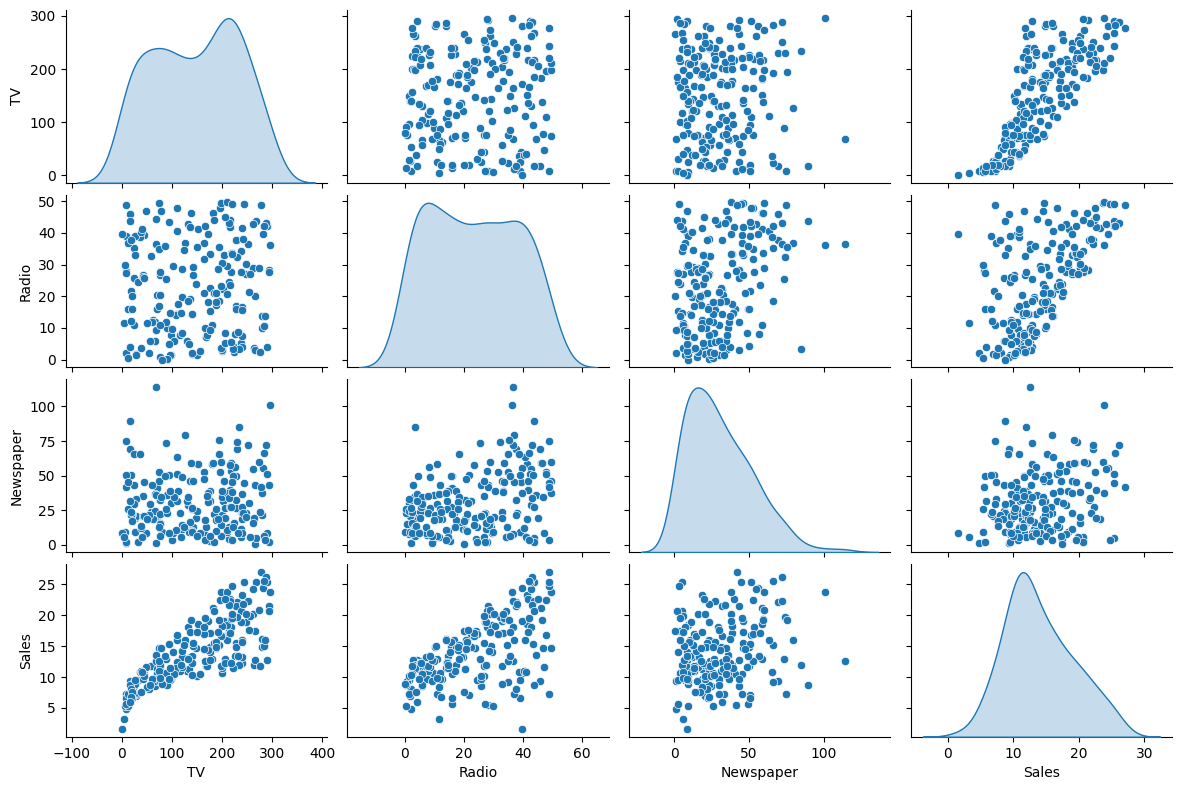

In [117]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

heatmap = plt.pcolor(correlation_matrix, cmap='coolwarm')

plt.colorbar(heatmap)

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)

for i in range(len(correlation_matrix.index)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

plt.clf()

sns.pairplot(df, height=2, aspect=1.5, diag_kind='kde')
plt.show()

# 2. Realizar los modelos de regresión lineal simple

In [118]:
def linear_regression(x, y):
    n = len(x)
    x_mean, y_mean = np.mean(x), np.mean(y)
    xy_sum = np.sum(x * y)
    xx_sum = np.sum(x * x)

    slope = (n * xy_sum - np.sum(x) * np.sum(y)) / (n * xx_sum - np.sum(x) ** 2)
    intercept = y_mean - slope * x_mean

    return slope, intercept

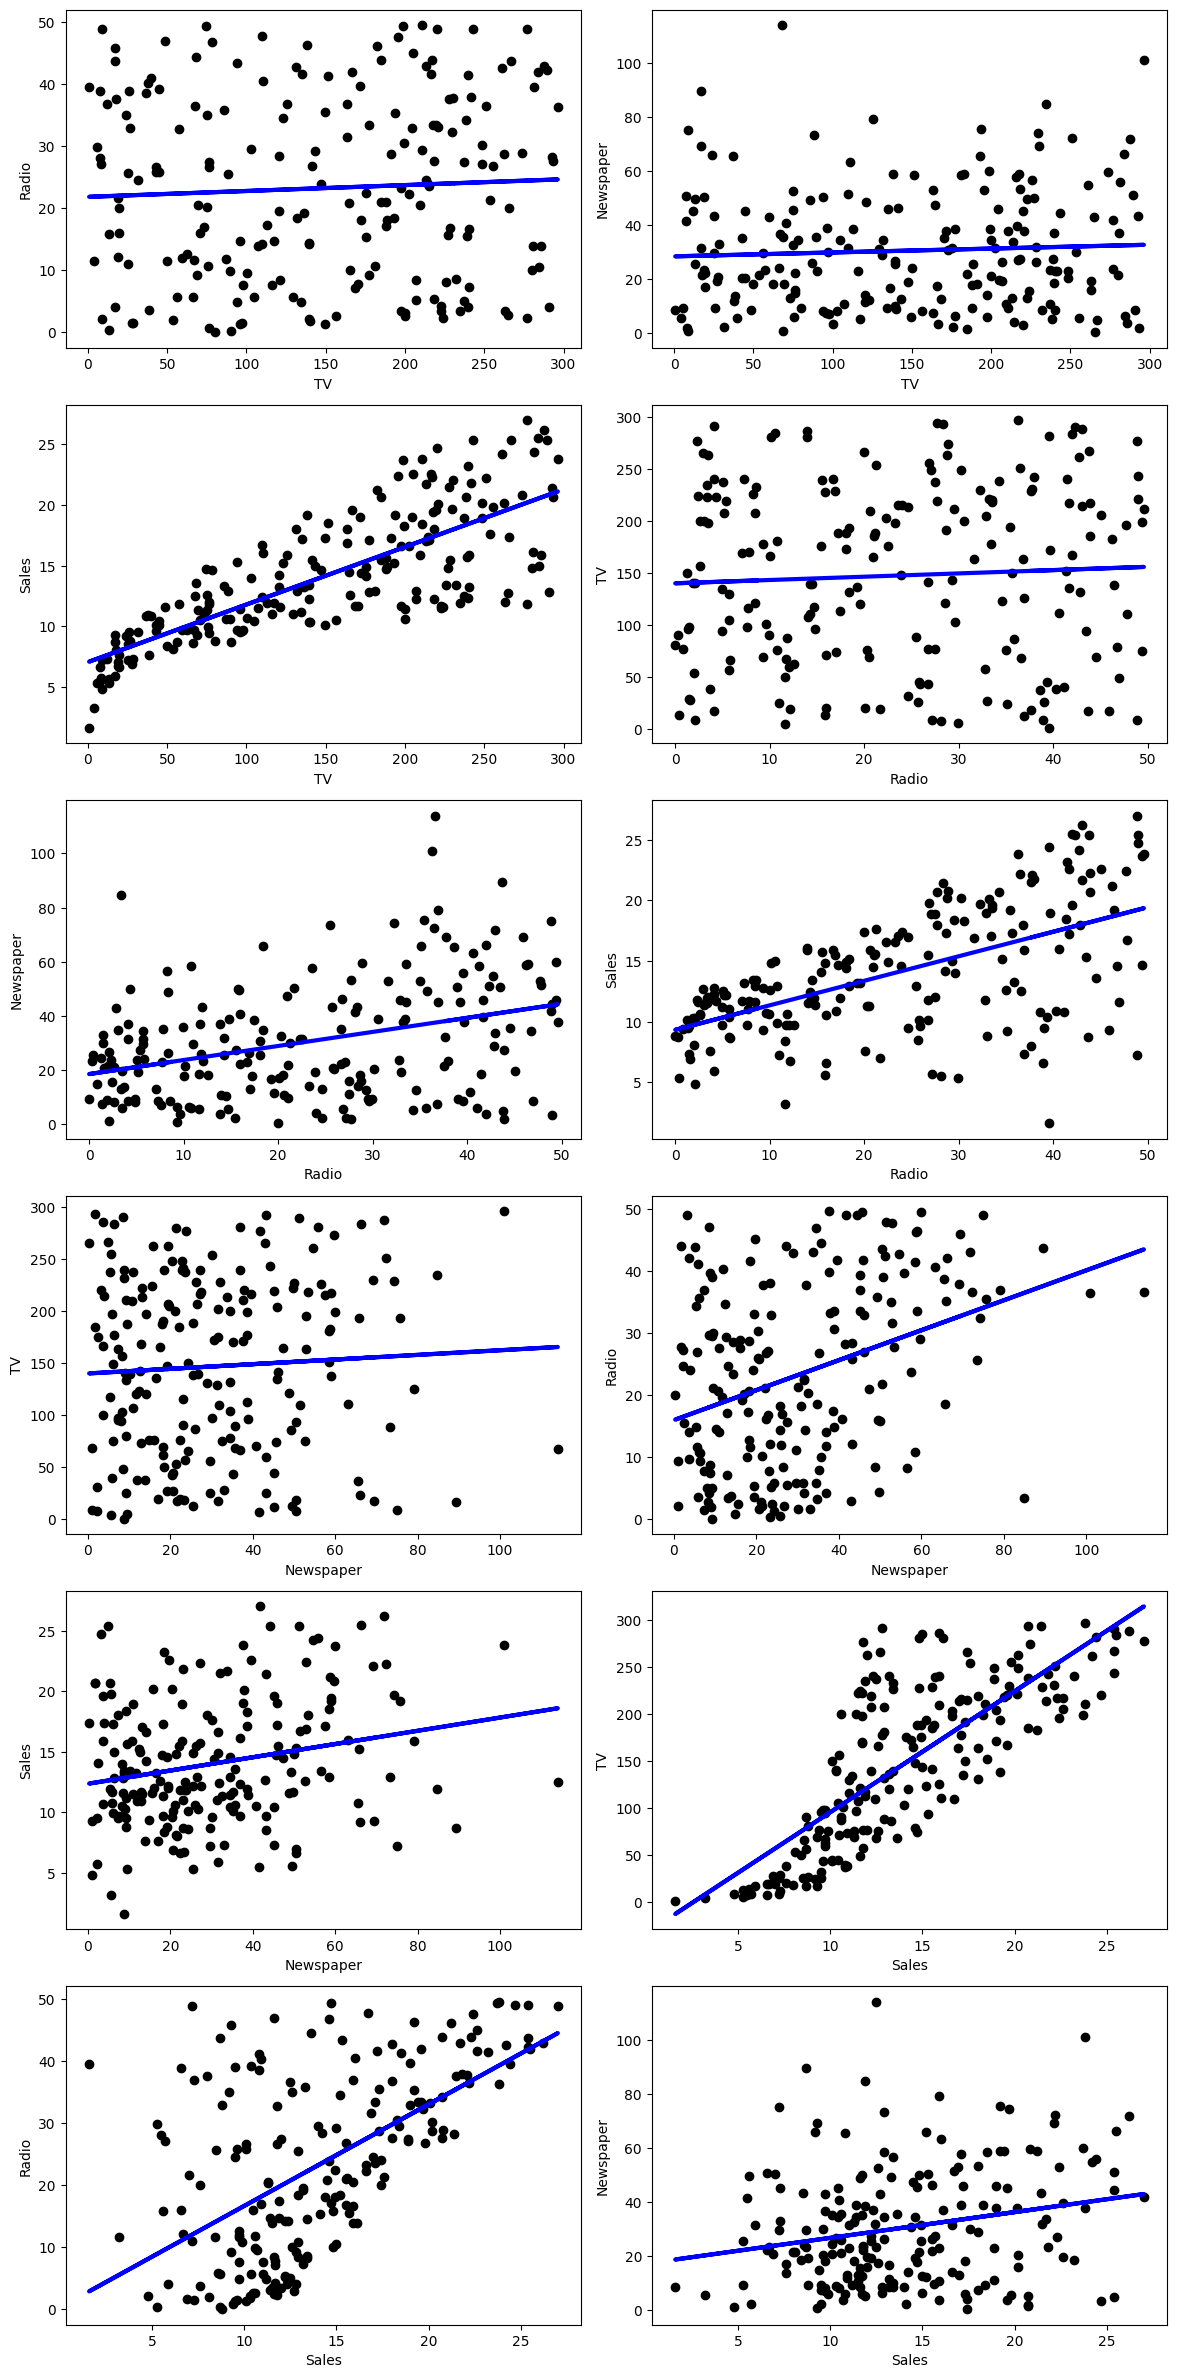

In [119]:
combinations = [(col1, col2) for col1 in df.columns for col2 in df.columns if col1 != col2]

fig, axes = plt.subplots(len(combinations)//2, 2, figsize=(12, 24))
fig.tight_layout(pad=2.0)

for (col1, col2), ax in zip(combinations, axes.flatten()):
    X_pair = df[col1]
    y_pair = df[col2]

    slope, intercept = linear_regression(X_pair, y_pair)
    y_pred = slope * X_pair + intercept

    ax.scatter(X_pair, y_pair, color='black')
    ax.plot(X_pair, y_pred, color='blue', linewidth=3)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    

plt.show()

In [120]:
metrics = []

combinations = [(col1, col2) for col1 in df.columns for col2 in df.columns if col1 != col2]

for (col1, col2) in combinations:
    X_pair = df[col1]
    y_pair = df[col2]
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.2, random_state=42)

    slope, intercept = linear_regression(X_train, y_train)

    y_pred = slope * X_test + intercept

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics.append((col1, col2, mse, r2))

metrics_df = pd.DataFrame(metrics, columns=['Variable_1', 'Variable_2', 'MSE', 'R^2'])

print(metrics_df)

   Variable_1 Variable_2          MSE       R^2
0          TV      Radio   225.431997 -0.014028
1          TV  Newspaper   714.201908 -0.008281
2          TV      Sales    10.204654  0.676695
3       Radio         TV  8362.558831 -0.024167
4       Radio  Newspaper   668.449035  0.056311
5       Radio      Sales    23.248767  0.263431
6   Newspaper         TV  8329.856819 -0.020162
7   Newspaper      Radio   223.268822 -0.004297
8   Newspaper      Sales    30.620734  0.029872
9       Sales         TV  2674.894841  0.672404
10      Sales      Radio   169.119770  0.239273
11      Sales  Newspaper   688.100627  0.028568


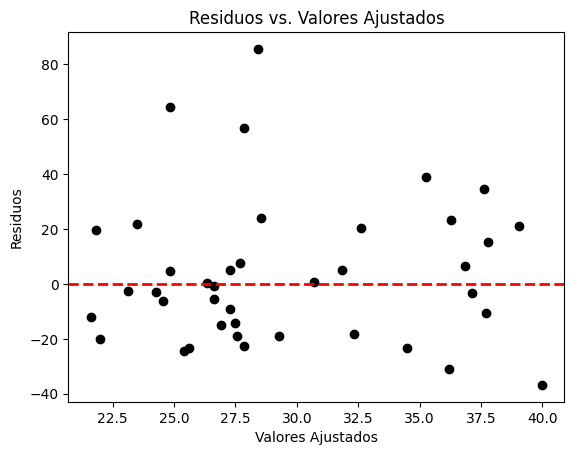

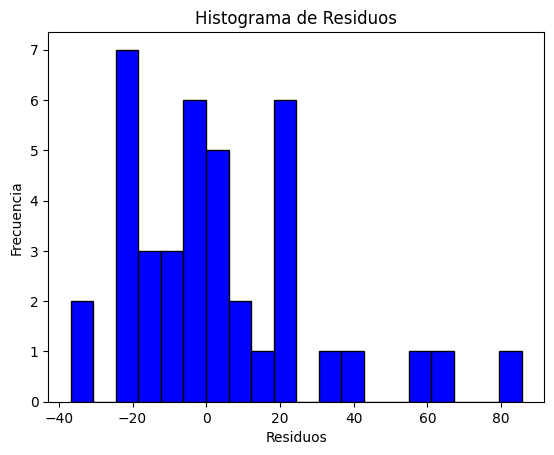

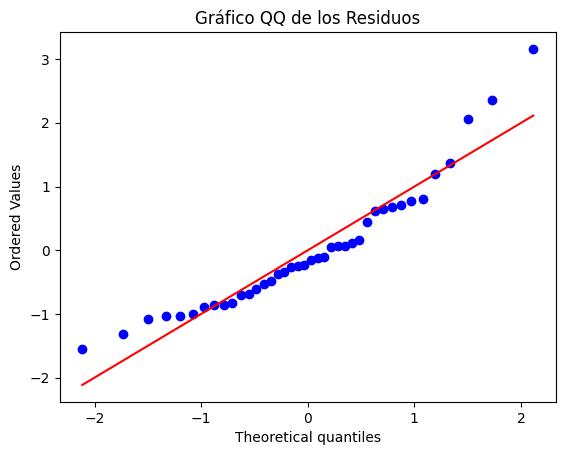

In [121]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, color='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs. Valores Ajustados')
plt.show()

plt.hist(residuals, bins=20, color='blue', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

residuals_standardized = (residuals - np.mean(residuals)) / np.std(residuals)

probplot(residuals_standardized, dist='norm', plot=plt)
plt.title('Gráfico QQ de los Residuos')
plt.show()

# 3. Realizar el modelo de regresión lineal múltiple

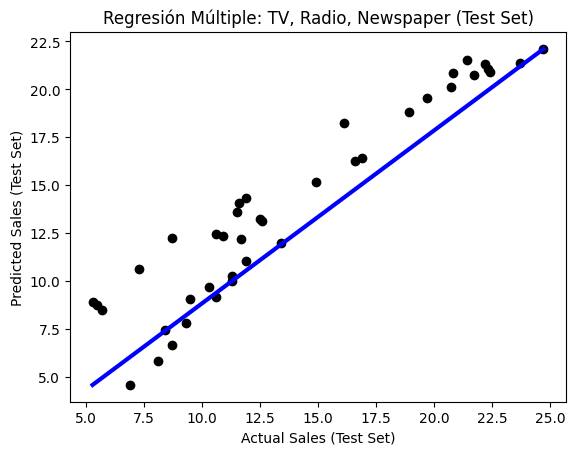

Mean Squared Error (MSE) - Test Set: 3.17
R-squared (R^2) - Test Set: 0.90


In [122]:
X = df[['TV', 'Radio', 'Newspaper']]
X = np.column_stack([np.ones(len(X)), X])

y = df['Sales']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcular los coeficientes de la regresión múltiple manualmente utilizando solo los datos de entrenamiento
coefficients = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Calcular las predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = X_train @ coefficients
y_test_pred = X_test @ coefficients

# Visualizar el rendimiento en el conjunto de prueba
plt.scatter(y_test, y_test_pred, color='black')
plt.plot([min(y_test), max(y_test)], [min(y_test_pred), max(y_test_pred)], color='blue', linewidth=3)
plt.xlabel('Actual Sales (Test Set)')
plt.ylabel('Predicted Sales (Test Set)')
plt.title('Regresión Múltiple: TV, Radio, Newspaper (Test Set)')
plt.show()

# Calcular métricas en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir métricas
print(f'Mean Squared Error (MSE) - Test Set: {mse_test:.2f}')
print(f'R-squared (R^2) - Test Set: {r2_test:.2f}')

In [123]:
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

metrics_df = pd.DataFrame({'MSE': [mse], 'R^2': [r2]})

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R^2): {r2:.2f}')

Mean Squared Error (MSE): 3.17
R-squared (R^2): 0.90


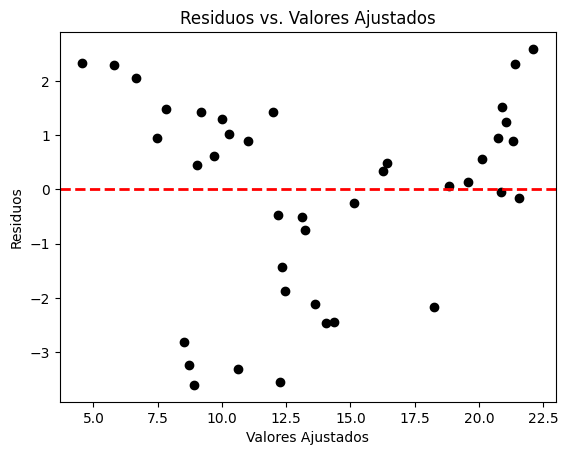

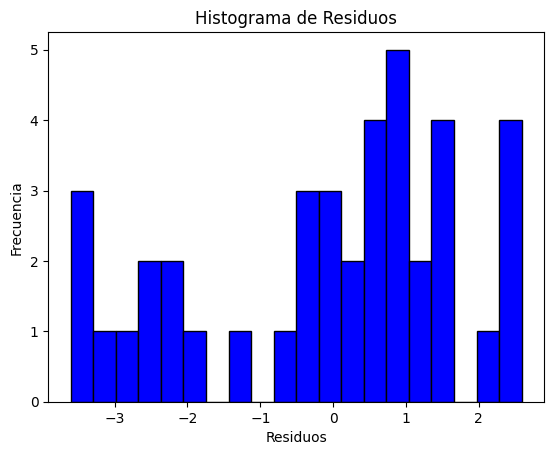

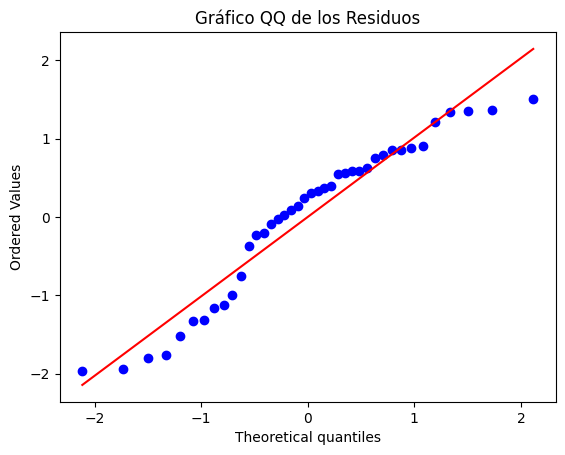

In [124]:
residuals = y_test - y_test_pred

plt.scatter(y_test_pred, residuals, color='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs. Valores Ajustados')
plt.show()

plt.hist(residuals, bins=20, color='blue', edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

residuals_standardized = (residuals - np.mean(residuals)) / np.std(residuals)

probplot(residuals_standardized, dist='norm', plot=plt)
plt.title('Gráfico QQ de los Residuos')
plt.show()